_Lambda School Data Science - Model Validation_

# HAVING FUN WITH CROSS-VALIDATION! — plus Feature Selection!

See also Sebastian Raschka's example, [Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb).

In [0]:
#!pip install seaborn --upgrade

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', 0)

## Here in we pull in all my feature creation functions

**`load`** - Loads and combines our data. 

**`split `** - Creates a test train split. 

**`ordinal `** - Creates a few date-based features as ordinal encoded variables. 

**`one_hot_encoded `** - Creates a few date-based features as one-hot encoded variables. 

**`jake_wrangle `** - Creates a few engineered features from Jake Vanderplas's DS Handbook.

**`wrangle `** - Applies `jake_wrangle` and creates a few engineered features from my classmates' insights.









In [0]:
# We'll modify a project from Python Data Science Handbook by Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic
    
# Predicting Bicycle Traffic

# As an example, let's take a look at whether we can predict the number of 
# bicycle trips across Seattle's Fremont Bridge based on weather, season, 
# and other factors.

# We will join the bike data with another dataset, and try to determine the 
# extent to which weather and seasonal factors—temperature, precipitation, 
# and daylight hours—affect the volume of bicycle traffic through this corridor. 
# Fortunately, the NOAA makes available their daily weather station data 
# (I used station ID USW00024233) and we can easily use Pandas to join 
# the two data sources.


import numpy as np
import pandas as pd
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor
from datetime import datetime
from datetime import date


def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
  
  
    daily.insert(0, 'ID', range(0, len(daily)))

    return daily

  
def ordinal(daily):
    daily = daily.copy()
    # Add a column of the dates
    daily['date_'] = daily.index
    
    # Date stuff https://docs.python.org/3/library/datetime.html#datetime.date.fromisoformat
    # Add some day context
    daily.insert(0, 'weekday_', daily.date_.apply(lambda x: x.weekday()))
    daily.insert(0, 'dayOfMonth_',  daily.date_.apply(lambda x: x.day))
    daily.insert(0, 'month_',  daily.date_.apply(lambda x: x.month))
    daily.insert(0, 'year_',  daily.date_.apply(lambda x: x.year))  
    
    # Drop date column
    daily = daily.drop(columns='date_')
    
    return daily
  
    
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    
    return X_train, X_test, y_train, y_test

  
  
def one_hot_encoded(X):
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    return X

  

def jake_wrangle(X):  
    X = X.copy()

    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

  

def wrangle(X):
    # From Daniel H (DS1 KotH)
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    X['PRCP_yest'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_ln'] = X['TMIN'] **2
    
    return X

 

In [3]:
# Download and join data into a dataframe
data = load()
data.head()

,ID,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,0,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,1,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,3,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,4,3537.0,0,0,0,211,78,19,2142.0


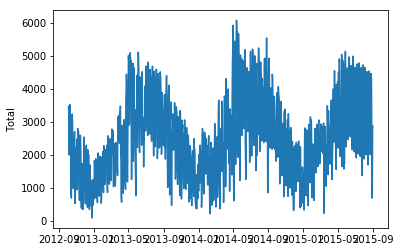

In [4]:
import seaborn as sns
sns.lineplot(data.index, data.Total)

## Now I'll calculate how various models perform! 

### I've converted my GridScore CV & Baseline to functions for easy use. 

In [0]:
# Rewriting my Dummy Regression Baseline one as a function
def baseline(data):
    name = "Dummy Regression Baseline"
    # Split data into train and test
    X_train, X_test, y_train, y_test = split(data)

    # Define an estimator and param_grid
    # WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
    pipe = make_pipeline(
        RobustScaler(), 
        DummyRegressor(strategy='mean'))
    pipe.fit(X_train, y_train)

    scorer = 'MAE'

    ### Get the scores with the MAE Function
    y_pred_train = pipe.predict(X_train)  
    y_pred_test = pipe.predict(X_test)

    train_score = mean_absolute_error(y_train, y_pred_train)
    test_score = mean_absolute_error(y_test, y_pred_test)
    score_variance = test_score - train_score
    cv_score = 0.0000000000000
    best_params = pipe.get_params
    best_estimator = ""
    selected_names = list(X_train.columns)
    unselected_names = []

    return [name, scorer, train_score, test_score, score_variance, cv_score, selected_names, unselected_names, best_params, best_estimator]


# Rewriting my GridSearch CV as a function 
def compare(data, name):
    X_train, X_test, y_train, y_test = split(data)

    pipe = make_pipeline(
        RobustScaler(), 
        SelectKBest(f_regression), 
        Ridge())

    param_grid = {
        'selectkbest__k': range(1, len(X_train.columns)+1), 
        'ridge__alpha': [0.1, 1.0, 10.]
    }

    scorer = 'MAE'

    # Fit on the train set, with grid search cross-validation
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                      scoring='neg_mean_absolute_error', 
                      verbose=0)
    gs.fit(X_train, y_train)

    train_score = -gs.score(X_train, y_train)
    test_score = -gs.score(X_test, y_test)
    score_variance = test_score - train_score
    cv_score = -gs.best_score_
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    # selected features? 
    # 'selectkbest' is the autogenerated name of the SelectKBest() function in the pipeline
    selector = gs.best_estimator_.named_steps['selectkbest']
    all_names = X_train.columns

    # get_support returns a mask of the columns in True / False
    selected_mask = selector.get_support()
    # Passing the boolean list as the column names creates a masked list.  
    selected_names = list(all_names[selected_mask])
    unselected_names = list(all_names[~selected_mask])

    return [name, scorer, train_score, test_score, score_variance, cv_score, selected_names, unselected_names, best_params, best_estimator]

### So I call my functions and show a table of the outcomes. 

In [6]:
# Going to call it now( )
%%time
variables = ["name","scorer","train_score","test_score","score_variance","cv_score","selected_features","unselected_features","best_params","best_estimator"]
gridCompare = []

# Call the Baseline function
baseliner = baseline(data)
gridCompare.append(baseliner)

# Prep the Data for each Compare Scenario
Z_data = data
A_data = ordinal(data)
B_data = one_hot_encoded(data)
C_data = one_hot_encoded(A_data)
D_data = wrangle(A_data)
E_data = wrangle(B_data)
F_data = wrangle(C_data)

# Call the Compare function for the other scenarios. 
dataz = [Z_data, A_data, B_data, C_data, D_data, E_data, F_data]
names = ["Ridge Baseline",'Just Ordinal','Just One Hot','Ord + One Hot','Wrangled + Ordinal','Wrangled + OH','All Combined']
for i, j in zip(dataz, names): gridCompare.append(compare(i,j))
gridComp = pd.DataFrame(gridCompare, columns = variables)

CPU times: user 37 s, sys: 22.6 s, total: 59.7 s
Wall time: 31 s


### The One Hot + Ordinal out performs either of them alone. 

In [7]:
gridComp.T.head(8)

,0,1,2,3,4,5,6,7
name,Dummy Regression Baseline,Ridge Baseline,Just Ordinal,Just One Hot,Ord + One Hot,Wrangled + Ordinal,Wrangled + OH,All Combined
scorer,MAE,MAE,MAE,MAE,MAE,MAE,MAE,MAE
train_score,980.898,601.751,385.55,290.97,290.953,362.645,272.788,272.833
test_score,1341.21,773.107,448.714,625.799,635.768,414.397,335.934,333.885
score_variance,360.307,171.356,63.164,334.829,344.815,51.7527,63.1461,61.0522
cv_score,0,604.645,389.212,317.006,316.724,375.381,297.196,297.141
selected_features,"[ID, PRCP, SNOW, SNWD, TMAX, TMIN, AWND, Total_yesterday]","[PRCP, TMAX, TMIN, Total_yesterday]","[weekday_, PRCP, TMAX, TMIN, Total_yesterday]","[ID, PRCP, SNWD, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Sep, Nov, Dec]","[year_, weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Nov, Dec]","[weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]","[ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Sep, Nov, Dec, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]","[year_, weekday_, ID, PRCP, TMAX, TMIN, AWND, Total_yesterday, Mon, Tue, Wed, Thu, Sat, Sun, holiday, Jan, Feb, Mar, May, Jun, Jul, Aug, Nov, Dec, daylight_hrs, Temp (C), dry day, annual, PRCP_yest, Windchill, Rl_Cold, TMIN_ln]"
unselected_features,[],"[ID, SNOW, SNWD, AWND]","[year_, month_, dayOfMonth_, ID, SNOW, SNWD, AWND]","[SNOW, Fri, Apr, Oct]","[month_, dayOfMonth_, SNOW, SNWD, Fri, Apr, Sep, Oct]","[year_, month_, dayOfMonth_, SNOW, SNWD]","[SNOW, SNWD, Fri, Apr, Oct]","[month_, dayOfMonth_, SNOW, SNWD, Fri, Apr, Sep, Oct]"


Remember: If your dataset is massive, be sure to take a random subset sample to try fitting with the training data to start getting scores. 

### Notes on Pipeline / GridScore

#### Using scoring functions different than the GridSearchCV `Scorer`

You can use a different scorer by simply calling the sklearn.metric function for the alternative scorer on the y-actual vs y-predicted for the fitted model. 


In [0]:
"""
# Using MAE function as standalone metric
y_pred = gs.predict(X_test)
test_score = mean_absolute_error(y_test, y_pred)
print('Test Score:', test_score)
""";

#### Using the GridSearch's `score` method to get the final test score. 

This method just generates the test predictions and scores them, returning the test score to you.

For negative metrics you apply the negative symbol to flip the sign from negative to positive.

In [0]:
"""
train_score = gs.score(X_train, y_train)
test_score = gs.score(X_test, y_test)

print('Train Score:', -train_score)
print('Test Score:', -test_score)
""";

#### Functions before re-*writing*

In [0]:
"""### HOW MY BASELINE FUNCTION LOOKED BEFORE
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    DummyRegressor(strategy='mean'))

pipe.fit(X_train, y_train)

### Get the scores with the MAE Function
## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_train)
dummy_train_score = mean_absolute_error(y_train, y_pred)
print('Dummy Regression Train Score:', dummy_train_score)


## Predict with X_test features and Compare predictions to y_test labels
y_pred = pipe.predict(X_test)
dummy_test_score = mean_absolute_error(y_test, y_pred)
print('Dummy Regression Test Score:', dummy_test_score)

### HOW MY PIPELINE FUNCTION LOOKED BEFORE
# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
RidgeBaseline_train_score = gs.score(X_train, y_train)
print('RidgeBaseline Train Score:', -RidgeBaseline_train_score)

RidgeBaseline_test_score = gs.score(X_test, y_test)
print('RidgeBaseline Test Score:', -RidgeBaseline_test_score)""";

#### You can use Function Transformer to pass through functions into GridSearchCV

In [0]:
'''def vary_scale(typ): 
  if typ=='robust': return RobustScaler
  elif typ=='standard': return StandardScaler
  else: Fail

pipe = Pipeline(steps=[  ... , ('scale', FunctionTransformer(vary_scale)), ... ])

param_grid = { 
    ... , 
    FunctionTransformer'vary_scale__choice': ['robust', 'standard'],
    ... }

search = GridSearchCV(pipe, param_grid, ...)''';

## Now I'll try another step, this one is adding PolynomialFeatures. 

In [12]:
%%time
ordinal_data = ordinal(data)
ord_oh_data = one_hot_encoded(ordinal_data)
wrangled_oh_ord_data = wrangle(ord_oh_data)

# Split data into train and test
X_train, X_test, y_train, y_test = split(wrangled_oh_ord_data)

# Define an estimator and param_grid
# WHEN DEFINING YOU CAN GIVE IT A NAME OTHERWISE IT WILL USE THE PIPELINE NAME AUTOGEN NAME (name of the function but lowercase)
pipe = make_pipeline(
    RobustScaler(), 
    PolynomialFeatures(degree=2),
    SelectKBest(f_regression), 
    Ridge())

param_grid = {
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=0)

gs.fit(X_train, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()


### Get the score with the GridSearch's score method
# It combines the predict and score calculation.
fe_train_score = gs.score(X_train, y_train)
print('Feature Engineered Train Score:', -fe_train_score)

fe_test_score = gs.score(X_test, y_test)
print('Feature Engineered Test Score:', -fe_test_score)


Cross-Validation Score: 337.3047538164374

Best estimator: Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('selectkbest', SelectKBest(k=36, score_func=<function f_regression at 0x7f19fa1bcd90>)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Feature Engineered Train Score: 276.24247184972216
Feature Engineered Test Score: 395.80984993785677
CPU times: user 35.8 s, sys: 24.4 s, total: 1min
Wall time: 30.3 s


## BONUS: Recursive Feature Elimination!

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [17]:
from sklearn.feature_selection import RFECV

X_train_scaled = RobustScaler().fit_transform(X_train)
rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', cv=3)
X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

all_names = X_train.columns
selected_mask = rfe.support_
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:',list(selected_names))
print('Features not selected:',list(unselected_names))

Features selected: ['dayOfMonth_', 'weekday_', 'PRCP', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Oct', 'Dec', 'daylight_hrs', 'Temp (C)', 'dry day', 'Windchill', 'Rl_Cold', 'TMIN_ln']
Features not selected: ['year_', 'month_', 'ID', 'SNOW', 'SNWD', 'Jan', 'Jul', 'Aug', 'Sep', 'Nov', 'annual', 'PRCP_yest']


## RFE again, but with polynomial features and interaction terms!

### Apply a Polynomial Transformation

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_polynomial = poly.fit_transform(X_train)

print(X_train.shape, X_train_polynomial.shape)

(963, 40) (963, 861)


### Apply a Scaler & RFECV

In [19]:
%%time
from sklearn.feature_selection import RFECV

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_polynomial)

rfe = RFECV(Ridge(alpha=1.0), scoring='neg_mean_absolute_error', 
            step=10, cv=3, verbose=0)

X_train_subset = rfe.fit_transform(X_train_scaled, y_train)

CPU times: user 16.2 s, sys: 15.6 s, total: 31.8 s
Wall time: 16.1 s


### Look at all of those new features!


In [21]:
all_names = poly.get_feature_names(X_train.columns)
selected_mask = rfe.support_
selected_names = [name for name, selected in zip(all_names, selected_mask) if selected]
print('Features selected:',list(selected_names))

Features selected: ['year_', 'PRCP', 'TMAX', 'year_ dayOfMonth_', 'year_ TMAX', 'month_ Fri', 'month_ Sat', 'month_ Sun', 'dayOfMonth_ ID', 'dayOfMonth_ TMAX', 'dayOfMonth_ TMIN', 'dayOfMonth_ AWND', 'dayOfMonth_ Total_yesterday', 'dayOfMonth_ daylight_hrs', 'dayOfMonth_ Temp (C)', 'dayOfMonth_ annual', 'weekday_ holiday', 'weekday_ Jan', 'weekday_ Feb', 'weekday_ May', 'weekday_ Aug', 'weekday_ Dec', 'weekday_ dry day', 'ID^2', 'ID AWND', 'ID daylight_hrs', 'ID Temp (C)', 'ID dry day', 'ID annual', 'ID Rl_Cold', 'PRCP TMAX', 'PRCP TMIN', 'PRCP Wed', 'PRCP Thu', 'PRCP Sat', 'PRCP Sun', 'PRCP holiday', 'PRCP Jan', 'PRCP Feb', 'PRCP Mar', 'PRCP Apr', 'PRCP May', 'PRCP Jun', 'PRCP Jul', 'PRCP Aug', 'PRCP Sep', 'PRCP Nov', 'PRCP daylight_hrs', 'PRCP Rl_Cold', 'TMAX^2', 'TMAX TMIN', 'TMAX Mar', 'TMAX Apr', 'TMAX Jul', 'TMAX Dec', 'TMAX dry day', 'TMAX Rl_Cold', 'TMAX TMIN_ln', 'TMIN AWND', 'TMIN Mar', 'TMIN Apr', 'TMIN Jun', 'TMIN Jul', 'TMIN dry day', 'AWND Total_yesterday', 'AWND Jul', 'A

### Now we can experiment with mulitple ridge settings for selecting features. 

In [22]:
# Define an estimator and param_grid

ridge = Ridge()

param_grid = {
    'alpha': [0.1, 0.75, 1.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3.0, 4.0, 10.]
}

# Fit on the train set, with grid search cross-validation
gs = GridSearchCV(ridge, param_grid=param_grid, cv=3, 
                  scoring='neg_mean_absolute_error', 
                  verbose=1)

gs.fit(X_train_subset, y_train)
validation_score = gs.best_score_
print()
print('Cross-Validation Score:', -validation_score)
print()
print('Best estimator:', gs.best_estimator_)
print()

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Cross-Validation Score: 256.61330969002734

Best estimator: Ridge(alpha=2.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)



[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.5s finished


In [23]:
# Do the same transformations to X_test (Applying the same transformations to each set so we can check the test scores)
X_test_polynomial = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_polynomial)
X_test_subset = rfe.transform(X_test_scaled)

# Use the grid search's score method with X_test_subset
train_score = gs.score(X_train_subset, y_train)
print('Train Score:', -train_score)
test_score = gs.score(X_test_subset, y_test)
print('Test Score:', -test_score)

Train Score: 197.61173458116826
Test Score: 356.485481175808
